# Group 2 Capstone Project
####*Classification of Brain Tumour Subtypes Using Multilayer Perceptrons on Gene Expression Data*
---
Participants:
<pre>
Name                         Student Number
*   Arman Torabi (Team lead) (1058001)
*   Gerrit van Aalst         (1035187)
*   Jesse de Zeeuw           (1058515)
*   Martijn Warnas           (1048740)
*   Thom Veldhuis            (1055805)
</pre>

<quote>Grote stappen zet je doormiddel van kleine</quote>

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn requests HTSeq pip shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 29.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
warnings.simplefilter(action='always', category=UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

# Loading dataset

In [ ]:
# Load dataset
# info: https://sbcb.inf.ufrgs.br/cumida
datasets = [
  "https://sbcb.inf.ufrgs.br/data/cumida/Genes/Brain/GSE15824/Brain_GSE15824.csv",
  "https://sbcb.inf.ufrgs.br/data/cumida/Genes/Brain/GSE50161/Brain_GSE50161.csv",
]
li = []

# It are two different datasets to use, these need to be combined
for filename in datasets:
    frame = pd.read_csv(filename, index_col=None, header=0)
    li.append(frame)

df = pd.concat(li, axis=0, ignore_index=True)
df.head(10)

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,GSM397626.CEL.gz,Glioblastoma,9.409264,6.486642,6.849118,5.553799,2.614667,6.465026,5.468213,3.088760,...,11.117198,10.995354,12.540305,12.393756,3.000946,2.229139,2.125375,1.849213,2.164977,2.247018
1,GSM397627.CEL.gz,Glioblastoma,9.566747,7.012791,7.269160,7.016673,3.370558,7.696889,5.180409,3.299861,...,10.996753,10.947164,12.487712,12.363095,2.815493,2.552860,2.017627,1.806097,2.094159,2.291342
2,GSM397628.CEL.gz,Glioblastoma,8.405845,5.699024,4.224252,6.538294,3.523430,6.086694,6.921622,3.058813,...,11.112277,11.034261,12.272104,12.084999,3.342329,2.236081,2.225670,2.030381,2.281967,2.808183
3,GSM397629.CEL.gz,Glioblastoma,9.495506,7.388342,5.716298,5.858912,3.943877,6.649459,5.413839,3.554260,...,10.815664,10.689521,12.418079,12.157467,2.811632,2.331273,1.980123,1.952916,1.972212,2.145180
4,GSM397630.CEL.gz,Glioblastoma,9.110781,5.543423,4.024291,5.249798,3.516682,5.777301,6.411266,3.139687,...,10.954677,10.900948,12.451990,12.209082,2.918800,2.175992,1.937505,1.895730,1.969136,2.271932
5,GSM397631.CEL.gz,Glioblastoma,9.226354,5.968728,4.495631,5.363556,2.251607,6.559561,5.996781,2.890363,...,10.968546,10.864976,12.328437,12.082989,2.896215,2.327318,1.951717,1.906260,2.219891,2.384204
6,GSM397632.CEL.gz,Glioblastoma,8.478062,5.786825,6.671486,6.436143,2.530027,7.299467,5.062427,3.201200,...,11.294952,11.225622,12.589394,12.401590,2.823969,2.307478,1.863370,1.912847,2.301992,2.300148
7,GSM397633.CEL.gz,Glioblastoma,9.521164,5.431737,5.271117,5.382145,2.545220,6.005704,6.244359,3.263587,...,11.271862,11.124799,12.774401,12.568273,3.109648,2.650821,1.977874,1.962005,2.133018,2.388085
8,GSM397634.CEL.gz,Glioblastoma,9.532858,6.439842,5.932710,5.573172,2.675819,7.208566,5.442161,4.078859,...,11.474033,11.436921,12.803138,12.631458,2.769663,2.552500,2.069632,1.976064,2.096190,2.392529
9,GSM397635.CEL.gz,Glioblastoma,9.241643,7.256543,5.173774,5.514862,2.384926,5.830368,5.176284,3.529091,...,11.000758,10.897470,12.449306,12.255046,2.856544,2.323015,2.059446,1.814223,2.006599,2.597138


In [ ]:
print("Data Overview:")
print(df.info())
print(df["type"].unique())

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Columns: 54677 entries, samples to AFFX-TrpnX-M_at
dtypes: float64(54675), object(2)
memory usage: 69.7+ MB
None
['Glioblastoma' 'Astrocytoma' 'Oligodendrioglioma'
 'glioblastoma-cell-line' 'ependymoma' 'glioblastoma' 'medulloblastoma'
 'normal' 'pilocytic_astrocytoma']


In [ ]:
# this takes very long lol
print("\nSummary Statistics:")
#print(df.describe())


Summary Statistics:


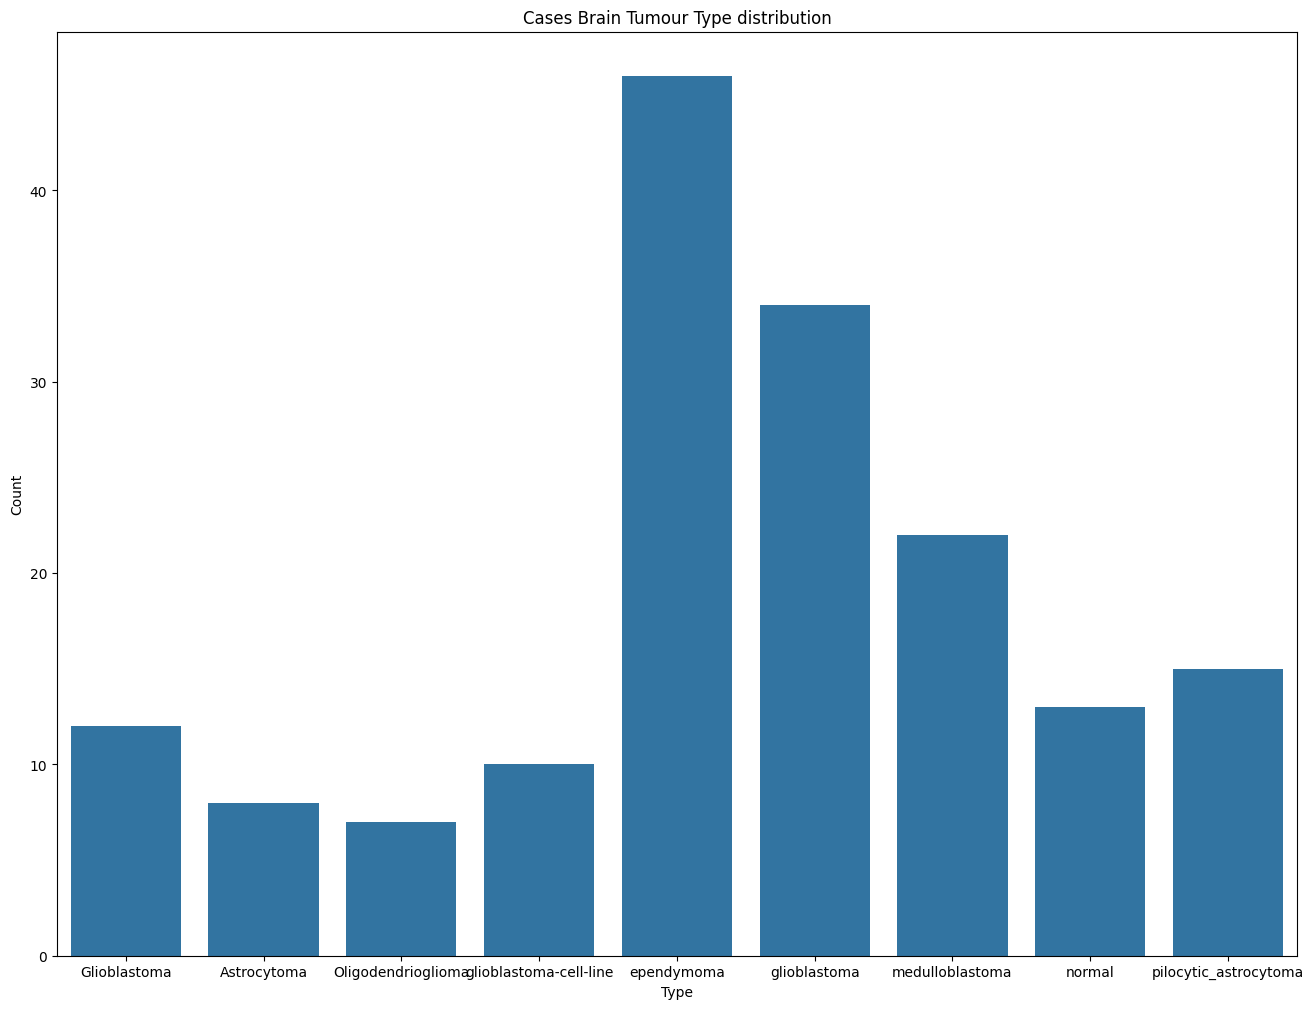

In [ ]:
plt.figure(figsize=(16, 12))
sns.countplot(x='type', data=df)
plt.title('Cases Brain Tumour Type distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

# Data pre-processing.

In [ ]:
# convert capital letters to the same (there are both Glioblastoma and glioblastoma)
df['type'] = df['type'].str.lower()
# sample is not needed for training, and such
X = df.drop(columns=['samples', 'type'])
# we want the type as the output of the models
y = df['type']
# for PCA and feature selection
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['type'])
y

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6,
       6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

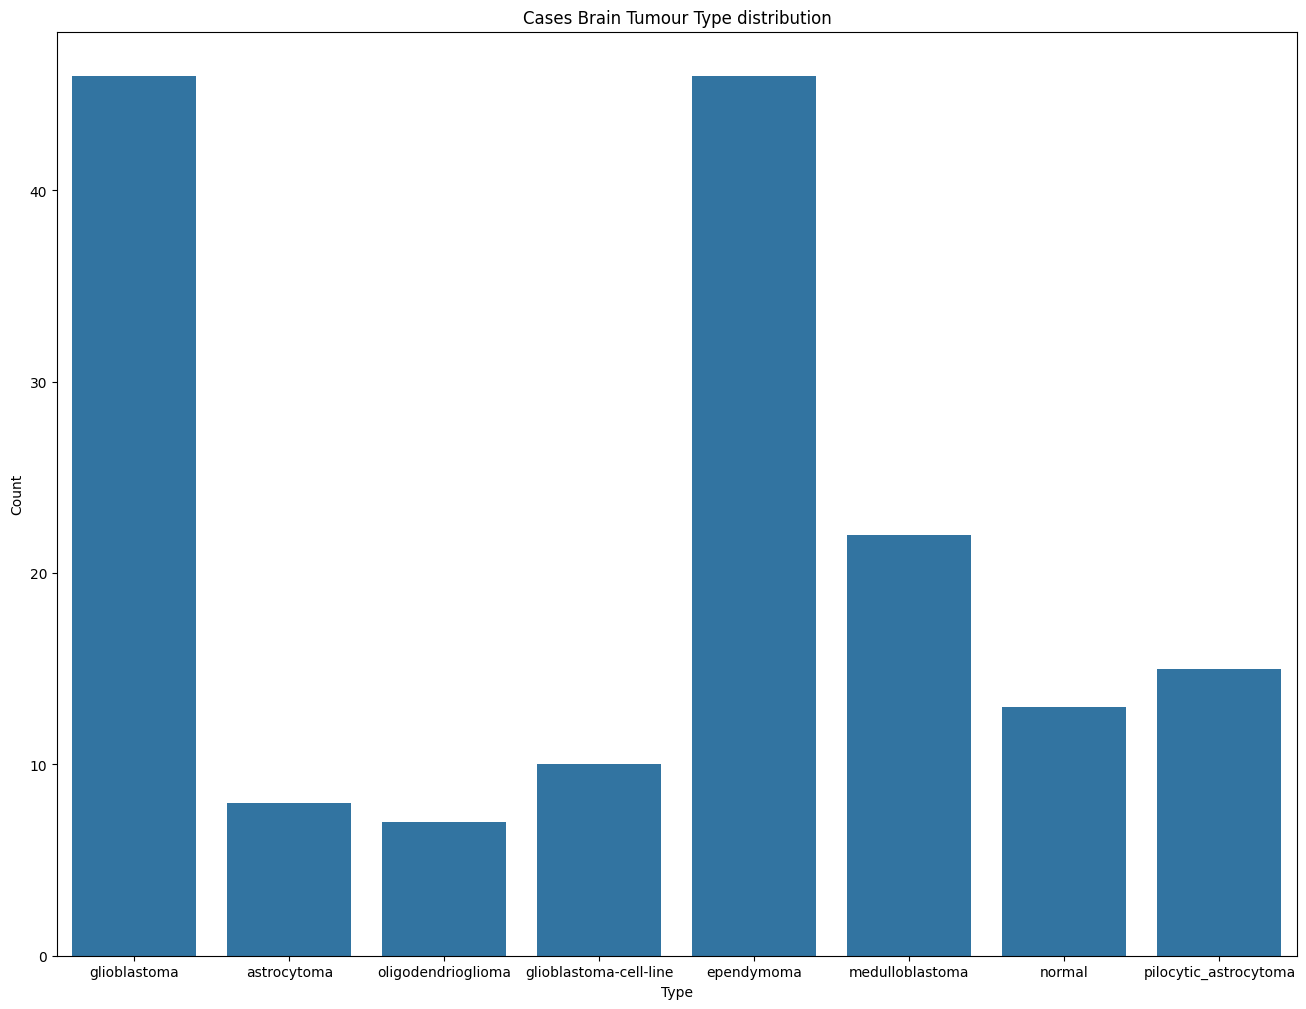

In [ ]:
plt.figure(figsize=(16, 12))
sns.countplot(x='type', data=df)
plt.title('Cases Brain Tumour Type distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

In [ ]:
# Initialize the standard scaler
scaler = StandardScaler()
# Scale the input features
X_scaled = scaler.fit_transform(X)
# Initialize SelectKBest to keep the top k features. The selection is based on
# statistical tests or scoring methods that evaluate the importance of each
# feature with respect to the target variable.
k = 1000
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_scaled, y)
print(X_selected[:5])

[[-1.5051602  -1.62947753 -1.4135778  ... -1.35040816 -1.50631063
  -0.66813905]
 [-1.40873347 -1.51254267 -1.29519797 ... -1.21869045 -1.41877735
  -0.11721131]
 [-1.31524395 -1.0699954  -1.18863525 ... -1.02421494 -1.26837582
  -0.69339259]
 [-1.29893161 -1.18896764 -1.1962369  ... -1.41172053 -1.42705108
  -1.81209576]
 [-1.53959485 -1.48656898 -1.33154935 ... -0.50430343 -1.51618395
  -1.59191748]]


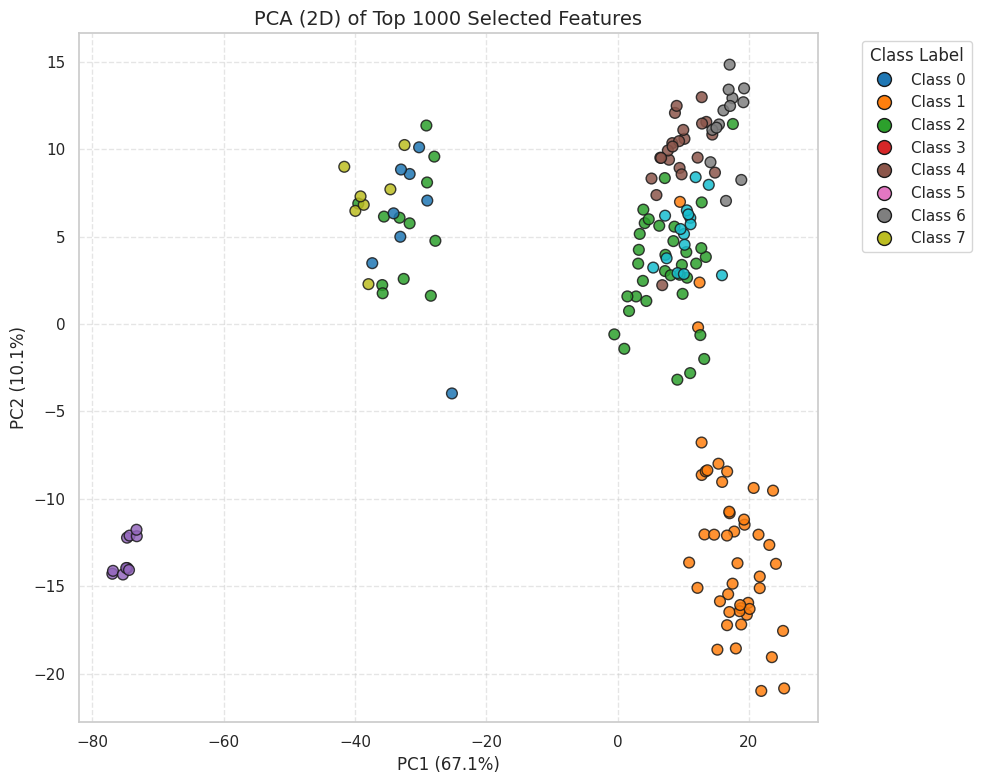

In [ ]:
# Reduce to 2D for visualization
# We can than see patterns in the features hopefully
pca_vis = PCA(n_components=5)
X_vis = pca_vis.fit_transform(X_selected)

sns.set(style="whitegrid", context="notebook")
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_vis[:, 0], X_vis[:, 1],
    c=y, cmap='tab10', edgecolor='k', s=60, alpha=0.85
)
plt.xlabel(f"PC1 ({pca_vis.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca_vis.explained_variance_ratio_[1]*100:.1f}%)")
plt.title(f"PCA (2D) of Top {k} Selected Features", fontsize=14)
classes = np.unique(y)
handles = [
    plt.Line2D([], [], marker='o', color='w', label=f"Class {cls}",
               markerfacecolor=plt.cm.tab10(i / len(classes)), markersize=10, markeredgecolor='k')
    for i, cls in enumerate(classes)
]
plt.legend(handles=handles, title="Class Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Splitting data in training and testing

In [ ]:
# traditional way before learning about StratifiedShuffleSplit :)
#X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
#print("Length of the training data:", len(X_train))
#print("Length of the test data:", len(X_test))

# Different splitting based on the features because the output classes are pretty different in count
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X_selected, y):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Training MLP Model


In [ ]:
num_labels = len(np.unique(y_train))
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

input_size = X_train.shape[1]

batch_size = 64
hidden_units = 256
dropout = 0.3

model = Sequential()
model.add(Input(shape=(input_size,)))
model.add(Dense(hidden_units, kernel_regularizer=l2(1e-4)))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units, kernel_regularizer=l2(1e-4)))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 324,104 (1.24 MB)

 Trainable params: 324,104 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optim = Adam(
    learning_rate=0.0001
)

model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('mlp_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
  X_train,
  y_train_categorical,
  validation_split=0.2,
  epochs=50,
  batch_size=batch_size,
  callbacks=[checkpoint, reduce_lr]
)

test_loss, test_acc = model.evaluate(X_test, y_test_categorical, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * test_acc))

predictions = model.predict(X_test)
print("Predicted:", np.argmax(predictions, axis=1))
print("True labels:", np.argmax(y_test_categorical, axis=1))

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.0826 - loss: 2.9987 - val_accuracy: 0.2963 - val_loss: 2.2827 - learning_rate: 1.0000e-04
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1998 - loss: 2.4141 - val_accuracy: 0.2963 - val_loss: 2.0958 - learning_rate: 1.0000e-04
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2761 - loss: 2.0785 - val_accuracy: 0.4444 - val_loss: 1.9634 - learning_rate: 1.0000e-04
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3150 - loss: 1.9006 - val_accuracy: 0.4815 - val_loss: 1.8641 - learning_rate: 1.0000e-04
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4236 - loss: 1.6444 - val_accuracy: 0.4815 - val_loss: 1.7752 - learning_rate: 1.0000e-04
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4488 - loss: 1.5010 - val_accuracy: 0.4444 - val_loss: 1.6891 - learning_rate: 1.0000e-04
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6108 - loss: 1.3244

In [ ]:
y_true_labels = np.argmax(y_test_categorical, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))

                        precision    recall  f1-score   support

           astrocytoma       1.00      0.50      0.67         2
            ependymoma       1.00      1.00      1.00         9
          glioblastoma       0.82      1.00      0.90         9
glioblastoma-cell-line       1.00      1.00      1.00         2
       medulloblastoma       1.00      1.00      1.00         5
                normal       1.00      1.00      1.00         3
    oligodendrioglioma       1.00      1.00      1.00         1
 pilocytic_astrocytoma       1.00      0.67      0.80         3

              accuracy                           0.94        34
             macro avg       0.98      0.90      0.92        34
          weighted avg       0.95      0.94      0.94        34



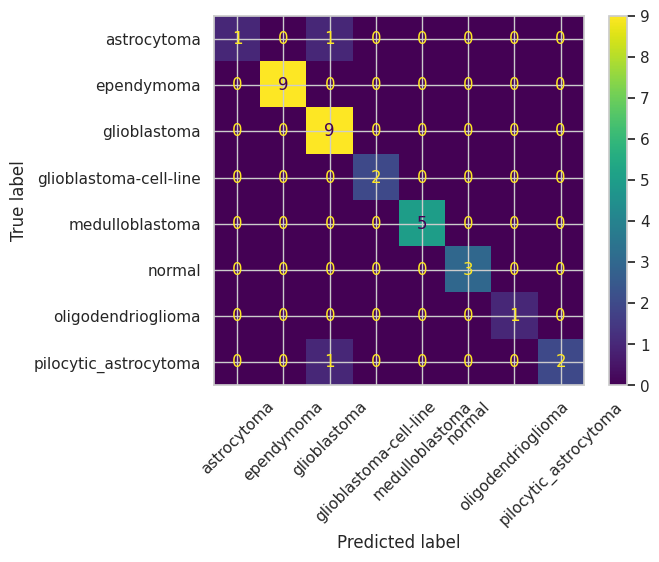

In [ ]:
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45)
plt.show()

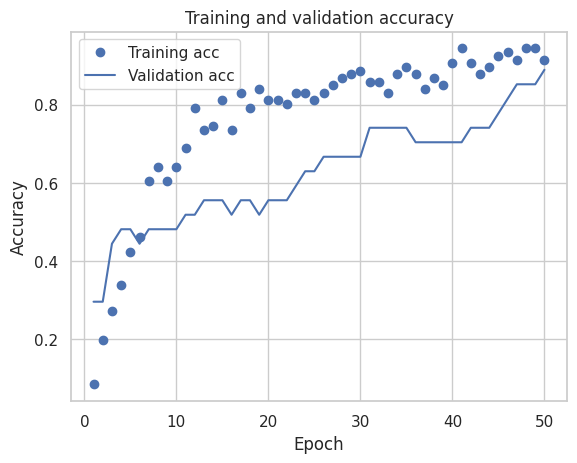

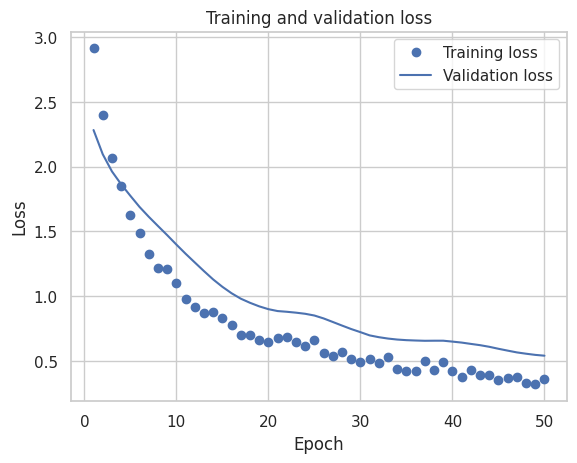

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Training Random Forest Classifier

In [ ]:
# Initialize the model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

In [ ]:
# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.9117647058823529

Classification Report:
                        precision    recall  f1-score   support

           astrocytoma       0.50      0.50      0.50         2
            ependymoma       1.00      1.00      1.00         9
          glioblastoma       0.82      1.00      0.90         9
glioblastoma-cell-line       1.00      1.00      1.00         2
       medulloblastoma       1.00      1.00      1.00         5
                normal       1.00      1.00      1.00         3
    oligodendrioglioma       0.00      0.00      0.00         1
 pilocytic_astrocytoma       1.00      0.67      0.80         3

              accuracy                           0.91        34
             macro avg       0.79      0.77      0.77        34
          weighted avg       0.89      0.91      0.90        34



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


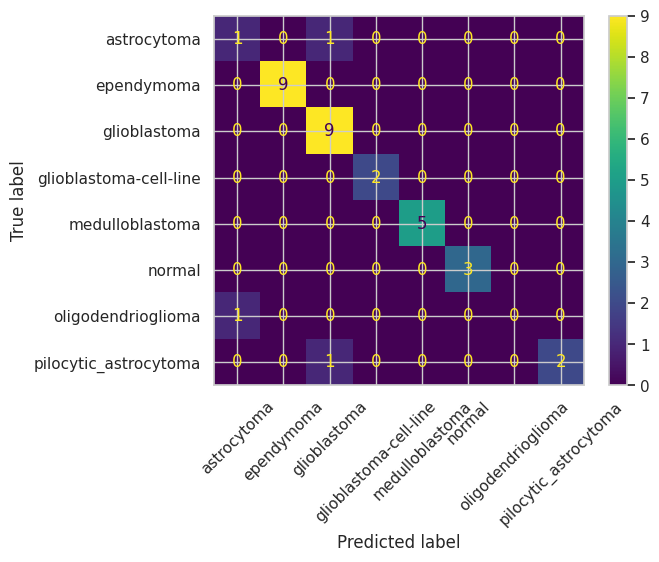

In [ ]:
# Confusion matrix to see class-wise performance
#cm = confusion_matrix(y_test, y_pred)
#plt.figure(figsize=(10, 7))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.title('Confusion Matrix')
#plt.show()

# Confusion Matrix
cm_r = confusion_matrix(y_test, y_pred)
disp_r = ConfusionMatrixDisplay(confusion_matrix=cm_r, display_labels=label_encoder.classes_)
disp_r.plot(xticks_rotation=45)
plt.show()

# Training Multinomial Logistic Regression

In [ ]:
# Training the model
y_test_categorical = to_categorical(y_test)

lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
# Evaluate the model
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\nTest accuracy: %.1f%%" % (100.0 * accuracy))
print("Predicted:", y_pred[:25])
print("True labels:", y_test[:25])


Test accuracy: 97.1%
Predicted: [6 2 4 4 1 1 2 2 1 4 4 1 2 1 2 1 5 7 3 0 1 1 2 7 3]
True labels: [6 2 4 4 1 1 2 2 1 4 4 1 2 1 2 1 5 7 3 0 1 1 2 7 3]


In [ ]:
# Classification report
y_true_labels_lr = np.argmax(y_test_categorical, axis=1)

print(classification_report(y_true_labels_lr, y_pred, target_names=label_encoder.classes_))

                        precision    recall  f1-score   support

           astrocytoma       1.00      0.50      0.67         2
            ependymoma       1.00      1.00      1.00         9
          glioblastoma       0.90      1.00      0.95         9
glioblastoma-cell-line       1.00      1.00      1.00         2
       medulloblastoma       1.00      1.00      1.00         5
                normal       1.00      1.00      1.00         3
    oligodendrioglioma       1.00      1.00      1.00         1
 pilocytic_astrocytoma       1.00      1.00      1.00         3

              accuracy                           0.97        34
             macro avg       0.99      0.94      0.95        34
          weighted avg       0.97      0.97      0.97        34



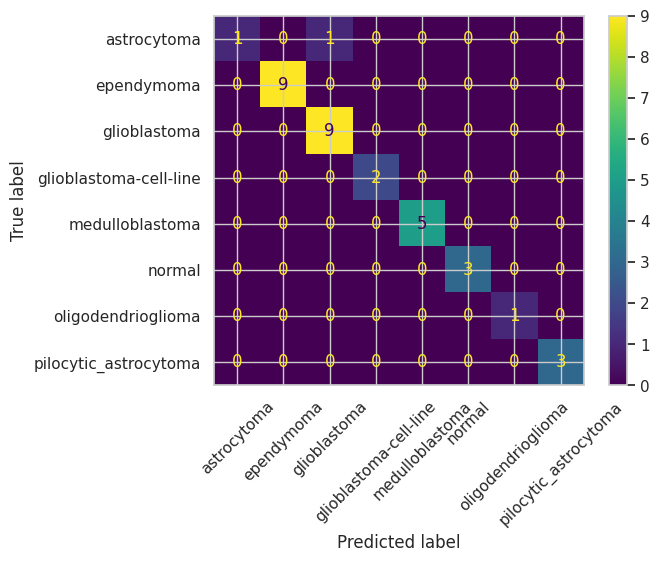

In [ ]:
# Confusion Matrix
cm_lr = confusion_matrix(y_true_labels_lr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45)
plt.show()

# Visualisation Techniques
####*Which visualisation techniques work best at enhancing the explainability of a MLP based brain tumor classification system*

Explainability of the MLP classification system is important, it will allow people not technologically inclined to still understand the data. The following methods have been deemed effective with the corresponding data, and now to determine which one works the best. Due to the amount of features (more then 50k) the visualisation will focus on returning the most influential features.


Most influential feature: 220448_at (mean |SHAP|: 0.5919)


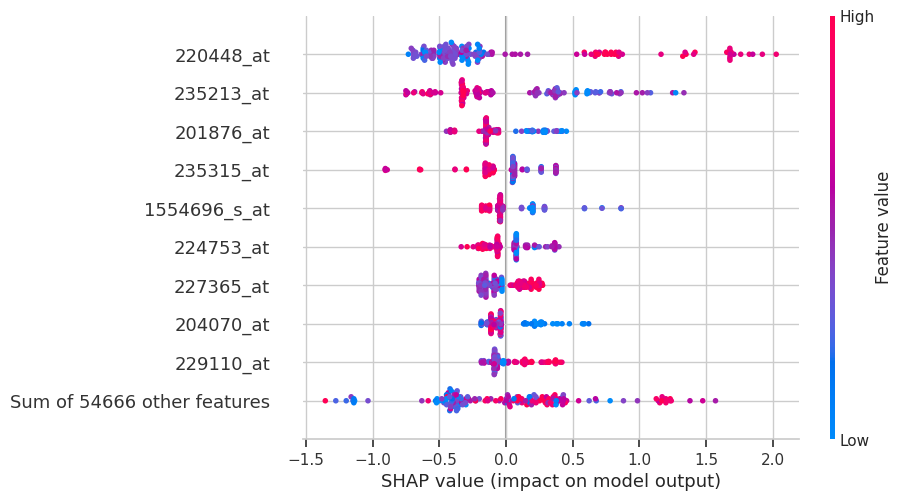

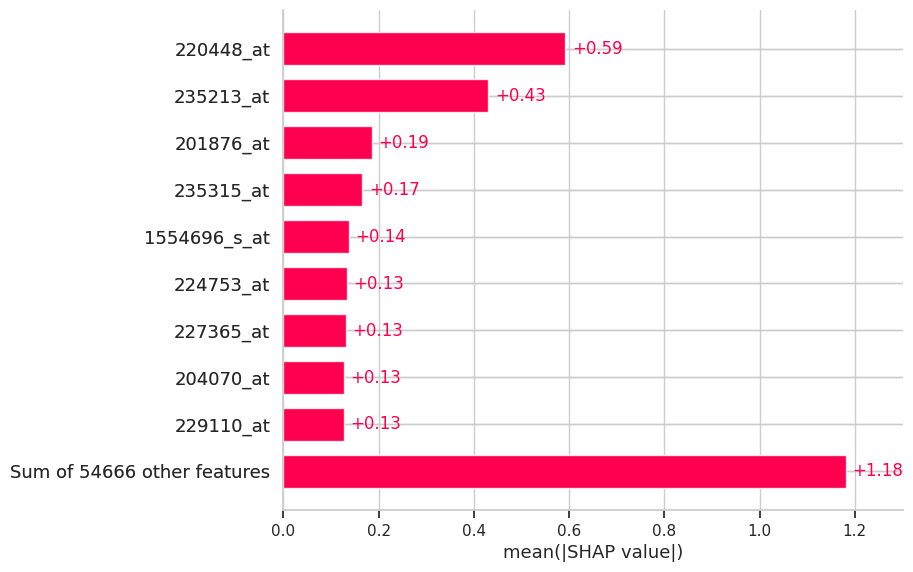

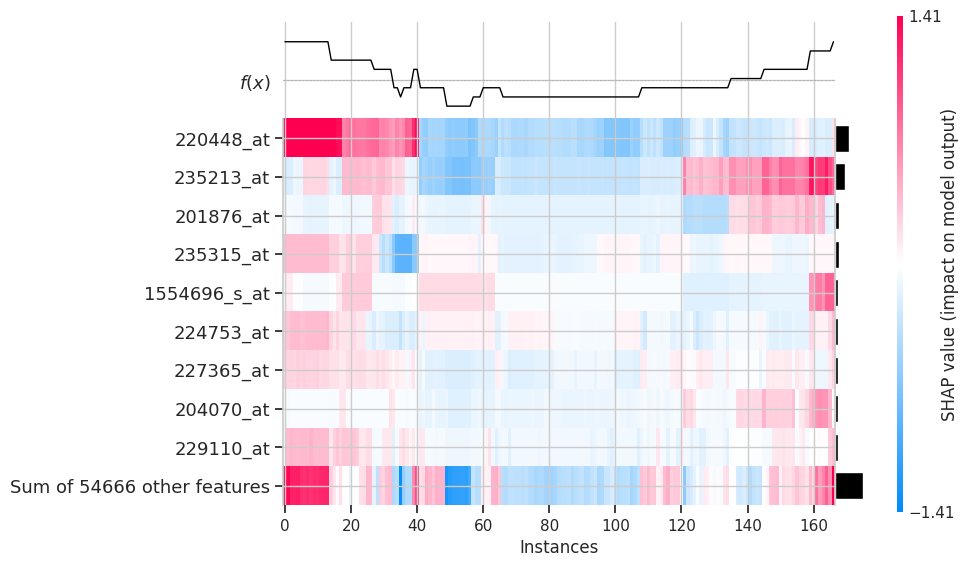

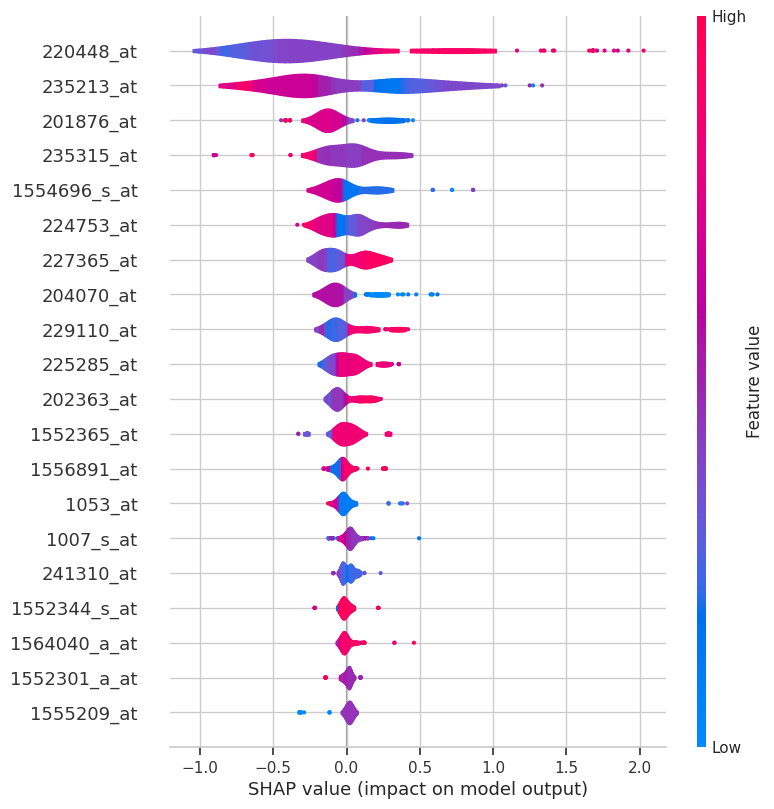

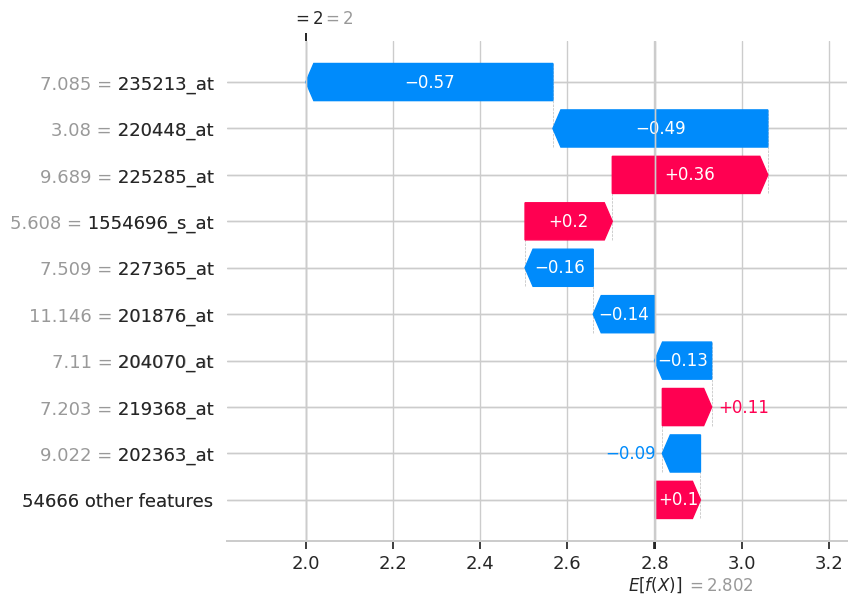

In [ ]:
import shap
import numpy as np
import pandas as pd
import xgboost

# Train model
model = xgboost.XGBRegressor().fit(X, y)

# Create SHAP explainer and compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Use provided names or fall back to generic names
if shap_values.feature_names is not None:
    feature_names = shap_values.feature_names
else:
    feature_names = [f"Feature {i}" for i in range(shap_values.values.shape[1])]

# Compute mean absolute SHAP values per feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# Find most influential feature
most_influential_index = np.argmax(mean_abs_shap)
most_influential_feature = feature_names[most_influential_index]
impact = mean_abs_shap[most_influential_index]

print(f"Most influential feature: {most_influential_feature} (mean |SHAP|: {impact:.4f})")


shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)
shap.plots.heatmap(shap_values)
shap.plots.violin(shap_values)
shap.plots.waterfall(shap_values[0])
